In [2]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import math
import random
import timeit

In [3]:
def find_pattern_ZeroMeanCorr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_zmc = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width]
            template = template - np.mean(template)
            zmc = np.sum(regionOfInterest * template)
            if zmc >= max_zmc:
                max_zmc = zmc
                x_max = x
                y_max = y
    return x_max, y_max

def find_pattern_SumSquaredDist(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    least_ssd = math.inf
    x_min = 0
    y_min = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width]
            diff = (regionOfInterest - template) ** 2
            ssd = np.sum(diff)
            if ssd <= least_ssd:
                least_ssd = ssd
                x_min = x
                y_min = y
    return x_min, y_min

def find_pattern_NormCrossCorr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_ncc = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width] - np.mean(im[y:y + template_height, x:x + template_width])
            template = template - np.mean(template)
            ncc = np.sum(regionOfInterest * template) / np.sqrt(np.sum(regionOfInterest ** 2) * np.sum(template ** 2))
            if ncc >= max_ncc:
                max_ncc = ncc
                x_max = x
                y_max = y
    return x_max, y_max

def find_pattern_Corr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_corr = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width]
            corr = np.sum(regionOfInterest * template)
            if corr >= max_corr:
                max_corr = corr
                x_max = x
                y_max = y
    return x_max, y_max

def rgb2gray_numpy(rgb_img):
    return np.dot(rgb_img[...,:3], [0.2989, 0.5870, 0.1140])

def test(input_image, template):
    window_size = template.shape
    y = np.lib.stride_tricks.as_strided(input_image,
                    shape=(input_image.shape[0] - window_size[0] + 1,
                           input_image.shape[1] - window_size[1] + 1,) +
                          window_size,
                    strides=input_image.strides * 2)
    ssd = np.einsum('ijkl,kl->ij', y, template)
    ssd *= - 2
    ssd += np.einsum('ijkl, ijkl->ij', y, y)
    ssd += np.einsum('ij, ij', template, template)

    return np.unravel_index(np.argmin(ssd), ssd.shape)


def homoMatrix(src, dst):
        A = np.zeros((8, 8))
        B = np.zeros((8, 1))
        for i in range(src.shape[0]):
            xs, ys = src[i]
            xd, yd = dst[i]
            A[i * 2] = [xs, ys, 1, 0, 0, 0, -xs * xd, -ys * xd]
            A[i * 2 + 1] = [0, 0, 0, xs, ys, 1, -xs * yd, -ys * yd]
            B[i * 2] = xd
            B[i * 2 + 1] = yd
        h = np.linalg.solve(A, B)
        h = np.append(h, 1)
        h = h.reshape((3, 3))
        return h
def warpPerspective(imgSrc, imgDst, src, dst):
    h = homoMatrix(src, dst)
    res = imgDst.copy()
    h_inv = np.linalg.inv(h)
    for y in range(imgDst.shape[0]):
        for x in range(imgDst.shape[1]):
            p = np.array([x, y, 1])
            p = np.dot(h_inv, p)
            p = p / p[2]
            if p[0] >= 0 and p[0] < imgSrc.shape[1] and p[1] >= 0 and p[1] < imgSrc.shape[0]:
                res[y, x] = imgSrc[int(p[1]), int(p[0])]
                #upscale factor
    return res

def warpInv(imgSrc, imgDst, src, dst):
    h = homoMatrix(src, dst)
    h_inv = np.linalg.inv(h)
    res = imgDst.copy()
    for y in range(imgSrc.shape[0]):
        for x in range(imgSrc.shape[1]):
            # found the corresponding point in the destination image
            p = np.array([x, y, 1])
            p = np.dot(h, p)
            p = p / p[2]
            if p[0] >= 0 and p[0] < imgDst.shape[1] and p[1] >= 0 and p[1] < imgDst.shape[0]:
                #print(p)
                res[int(p[1]), int(p[0])] = imgSrc[y, x]
    return res
    

In [ ]:
# Variables globales
# read it to a numpy array
img = image.imread('data/where_is_waldo.jpg')
template1 = image.imread('data/template1.png')
template2 = image.imread('data/template2.png')

img_gray = rgb2gray_numpy(img)
template1_gray = rgb2gray_numpy(template1)
template2_gray = rgb2gray_numpy(template2)


def test_metric(im, templates, func) :
    fig = plt.figure(figsize=(20, 20))
    id = 1
    for i in templates:
        x, y = func(im, i)
        res = im.copy()
        res[y:y + 100, x:x + 100] = 0
        ax = fig.add_subplot(1, len(templates), id)
        ax.imshow(res, cmap='gray')
        ax.set_title('x: ' + str(x) + ' y: ' + str(y))
        id += 1
    plt.show()

# https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html


In [ ]:
# time correlation
templates = [template1_gray, template2_gray]
test_metric(img_gray, templates, find_pattern_Corr)

In [ ]:
DO_BENCHMARK = 0 #Mettre a 0 pour éviter de run les benchmarks a chaque fois qu'on "run all" les cellules

if (DO_BENCHMARK):
    #functionsToBenchmark = [find_pattern_Corr, find_pattern_ZeroMeanCorr, find_pattern_NormCrossCorr, find_pattern_SumSquaredDist]
    functionsToBenchmark = {"find_pattern_Corr" : find_pattern_Corr, "find_pattern_ZeroMeanCorr": find_pattern_ZeroMeanCorr, "find_pattern_NormCrossCorr" : find_pattern_NormCrossCorr, "find_pattern_SumSquaredDist": find_pattern_SSD}

    ITERATIONS = 10

    print("-----------------------")
    print("------ Grayscale ------")
    print("-----------------------")
    for functionName in functionsToBenchmark:
        function = functionsToBenchmark[functionName]

        print("Time for " + functionName + ": ", end='')
        print(timeit.timeit(lambda: function(img_gray, template1_gray), number=ITERATIONS) / ITERATIONS, end='')
        print("s per iteration")





    print()
    print()
    print("-----------------------")
    print("--------- RGB ---------")
    print("-----------------------")
    for functionName in functionsToBenchmark:
        function = functionsToBenchmark[functionName]

        print("Time for " + functionName + ": ", end='')
        print(timeit.timeit(lambda: function(img, template1), number=ITERATIONS) / ITERATIONS, end='')
        print("s per iteration")

# Image transformation

In [9]:
bus = image.imread('data/bus.jpeg')

dstlt = (583, 209)
dstrt = (797, 229)
dstbl = (594, 517)
dstbr = (808, 466)

# dstlt = (1229, 1264)
# dstrt = (1940, 1274)
# dstbl = (1274, 2344)
# dstbr = (1983, 2289)

dst = np.array([dstlt, dstrt, dstbl, dstbr])

poster = image.imread('data/simpsons.jpeg')

srclt = (0, 0)
srctr = (poster.shape[1], 0)
srcbl = (0, poster.shape[0])
srcbr = (poster.shape[1], poster.shape[0])

src = np.array([srclt, srctr, srcbl, srcbr])

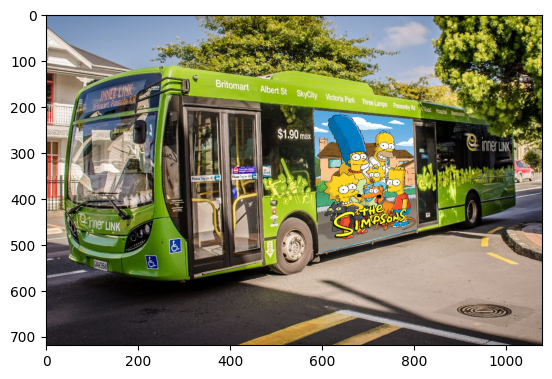

In [11]:
res = warpInv(poster, bus, src, dst)

plt.imshow(res)
plt.show()

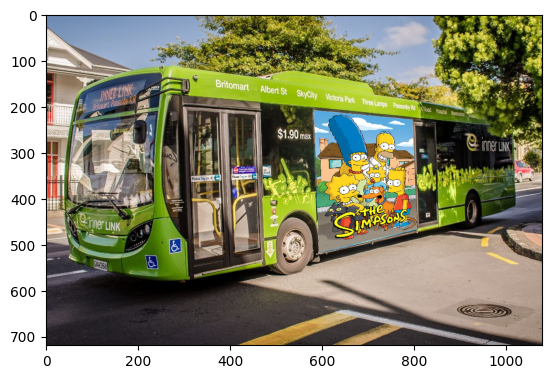

In [10]:
res = warpPerspective(poster, bus, src, dst)

plt.imshow(res)
plt.show()